In [4]:
%pip install sympy

Note: you may need to restart the kernel to use updated packages.


<h1>->Optimización de silueta NACA 2411 </h>

<h2>Importación de bibliotecas</h2>

In [5]:
import numpy as np                          #manejo de arrays y matrices, y proporciona funciones matemáticas avanzadas.
import psutil                               #Importa el módulo psutil. Este módulo se usa para obtener información sobre procesos y utilización del sistema (como memoria, CPU).
import math                                 #Importa el módulo math, que proporciona funciones matemáticas básicas y constantes.
from scipy.optimize import dual_annealing   #Importa la función 'dual_annealing' del submódulo optimize de SciPy. Esta función se utiliza para la optimización global.
import sympy                                #matemáticas simbólicas.
import subprocess                           #generar nuevos procesos, conectar a sus tuberías de entrada/salida/error, y obtener sus códigos de retorno.
import glob                                 #buscar archivos en un directorio que coincidan con un patrón especificado.
from queue import PriorityQueue             #proporciona la funcionalidad de una cola de prioridad.
import re as regex                          #soporte para trabajar con expresiones regulares.
import os                                   #proporciona una forma de usar funcionalidades dependientes del sistema operativo, como leer o escribir en el sistema de archivos.
import matplotlib.pyplot as plt             #visualizaciones estáticas, animadas e interactivas en Python.
from scipy.optimize import fsolve           #encontrar las raíces de una función.

<h2>1. Ingreso de coordenadas [x,y] para extrados e intrados</h2>

Nota: Se elimino el valor de conexión entre extrados e intrados [0,0] 

-> Extrados

In [6]:
xe=[1,0.93365,0.70475,0.44807,0.16175,0.0217]
ye=[0,0.0138,0.05158,0.07606,0.06659,0.02654]
print(" xe","\t"," ye")
matrix_length = len(xe)
for i in range(matrix_length):
    print(f"{xe[i]:.3f}","\t",f"{ye[i]:.3f}") 

 xe 	  ye
1.000 	 0.000
0.934 	 0.014
0.705 	 0.052
0.448 	 0.076
0.162 	 0.067
0.022 	 0.027


-> Intrados

In [7]:
xi=[0.02723,0.16912,0.4474,0.70198,0.93238,1]
yi=[-0.02061,-0.03379,-0.02637,-0.01436,-0.00326,0]
print(" xi","\t"," yi")
matrix_length = len(xi)
for i in range(matrix_length):
    print(f"{xi[i]:.3f}","\t",f"{yi[i]:.3f}") 

 xi 	  yi
0.027 	 -0.021
0.169 	 -0.034
0.447 	 -0.026
0.702 	 -0.014
0.932 	 -0.003
1.000 	 0.000


<h2>2. Sistema de ecuaciones para encontrar los coeficientes "a" de las funciones de extrados e intrados</h2>

->Calculo de coeficientes de la función de extrados

In [8]:
A = np.array([[pow(xe[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(ye)
sol_e = np.linalg.solve(A, b)
print(sol_e)


[ 0.18119909 -0.03827758 -0.44364229  0.56525658 -0.33368452  0.06914872]


->Calculo de coeficientes de la función de intrados

In [9]:
A = np.array([[pow(xi[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(yi)
sol_i = np.linalg.solve(A, b)
print(sol_i)

[-0.13611831  0.4344056  -0.85017457  1.121429   -0.79950799  0.22996628]


<h3>Nota: Aquí se verifican los resultados posteriores para y"emáx, y"imin, x_emax & x_imin

-> Calcular X_emax 


In [10]:
xee = sympy.symbols('xee')
fe = sum(sol_e[i]*xee**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fe, xee)

sol = sympy.solve(dy, xee)

def is_sol(xee):
    if sympy.im(xee) != 0:
        return False
    if xee < 0 or xee > 1:
        return False
    return True

x_eemax =float([xee for xee in sol if is_sol(xee)][0])
print("x_eemax=",x_eemax)

x_eemax= 0.34680341970639106


-> Calcular X_imax 

In [11]:
xii = sympy.symbols('xii')
fi = sum(sol_i[i]*xii**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fi, xii)

sol = sympy.solve(dy, xii)

def is_sol(xii):
    if sympy.im(xii) != 0:
        return False
    if xii < 0 or xii > 1:
        return False
    return True

x_imin = float([xii for xii in sol if is_sol(xii)][0])
print("x_imin=",x_imin)

x_imin= 0.18148093926360492


<h2>3. Parametrización del perfil original

-> Variables simbolicas, no son numeros. Se crean para desarrollar el sistema de ecuaciones

In [12]:
y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax, x_imax, dy_emax, dy_imax, r_bae,r_bai=sympy.symbols("y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax,x_imax, dy_emax, dy_imax, r_bae,r_bai")

->Los valores de ae & ai se vuelven simbolicos para emplearlo en el sistema (Iteradores)

In [13]:
ae=sympy.symbols("ae:6")
ai=sympy.symbols("ai:6")
k=sympy.symbols("k",integer=True)

-> Ecuaciones a resolver

In [14]:
eq1=sympy.sqrt(2*r_bai)+ai[0]
eq12=sympy.sqrt(2*r_bae)-ae[0]
#extrados
eq2 =sum([ae[k-1]*pow(x_emax, k-0.5) for k in range(1, 7)])-y_emax
eq3=sum([(k-0.5)*ae[k-1]*pow(x_emax, k-1.5) for k in range(1, 7)])
eq4=sum([(k-1.5)*(k-0.5)*ae[k-1]*pow(x_emax, k-2.5) for k in range(1, 7)])-dy_emax
eq5=sum([ae[k-1] for k in range(1, 7)])-y_bs+0.5*deltay_bs    #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq6=sum([(k-0.5)*ae[k-1] for k in range(1, 7)])-sympy.tan((2*alpha-beta)/2)
#intrados 
eq7=sum([ai[k-1]*pow(x_imax, k-0.5) for k in range(1, 7)])-y_imax
eq8=sum([(k-0.5)*ai[k-1]*pow(x_imax, k-1.5) for k in range(1, 7)])
eq9=sum([(k-1.5)*(k-0.5)*ai[k-1]*pow(x_imax, k-2.5) for k in range(1, 7)])-dy_imax
eq10=sum([ai[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs   #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq11=sum([(k-0.5)*ai[k-1] for k in range(1, 7)])-sympy.tan((2*alpha+beta)/2)
#Fueron igualadas a 0 para crear el sistema de solución con ayuda de sympy

-> Impresión de las ecuaciones 

In [15]:
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display(eq6)
display(eq7)
display(eq8)
display(eq9)
display(eq10)
display(eq11)
display(eq12)

ai0 + sqrt(2)*sqrt(r_bai)

ae0*x_emax**0.5 + ae1*x_emax**1.5 + ae2*x_emax**2.5 + ae3*x_emax**3.5 + ae4*x_emax**4.5 + ae5*x_emax**5.5 - y_emax

0.5*ae0/x_emax**0.5 + 1.5*ae1*x_emax**0.5 + 2.5*ae2*x_emax**1.5 + 3.5*ae3*x_emax**2.5 + 4.5*ae4*x_emax**3.5 + 5.5*ae5*x_emax**4.5

-0.25*ae0/x_emax**1.5 + 0.75*ae1/x_emax**0.5 + 3.75*ae2*x_emax**0.5 + 8.75*ae3*x_emax**1.5 + 15.75*ae4*x_emax**2.5 + 24.75*ae5*x_emax**3.5 - dy_emax

ae0 + ae1 + ae2 + ae3 + ae4 + ae5 + 0.5*deltay_bs - y_bs

0.5*ae0 + 1.5*ae1 + 2.5*ae2 + 3.5*ae3 + 4.5*ae4 + 5.5*ae5 - tan(alpha - beta/2)

ai0*x_imax**0.5 + ai1*x_imax**1.5 + ai2*x_imax**2.5 + ai3*x_imax**3.5 + ai4*x_imax**4.5 + ai5*x_imax**5.5 - y_imax

0.5*ai0/x_imax**0.5 + 1.5*ai1*x_imax**0.5 + 2.5*ai2*x_imax**1.5 + 3.5*ai3*x_imax**2.5 + 4.5*ai4*x_imax**3.5 + 5.5*ai5*x_imax**4.5

-0.25*ai0/x_imax**1.5 + 0.75*ai1/x_imax**0.5 + 3.75*ai2*x_imax**0.5 + 8.75*ai3*x_imax**1.5 + 15.75*ai4*x_imax**2.5 + 24.75*ai5*x_imax**3.5 - dy_imax

ai0 + ai1 + ai2 + ai3 + ai4 + ai5 - 0.5*deltay_bs - y_bs

0.5*ai0 + 1.5*ai1 + 2.5*ai2 + 3.5*ai3 + 4.5*ai4 + 5.5*ai5 - tan(alpha + beta/2)

-ae0 + sqrt(2)*sqrt(r_bae)

<h3>->Simplificación con suposición

In [16]:
eq=[ eq1, eq2,  eq4 , eq6, eq7, eq9, eq11, eq12] #Se crea un grupo para todas las ecuaciones, NOTA SE ELIMINA 3,5,8, 10 PORQUE VALEN 0!!!!
for i in range(len(eq)):
    for j in range(len(sol_e)):
        eq[i]=eq[i].subs(ae[j],sol_e[j])
    for j in range(len(sol_i)):
        eq[i]=eq[i].subs(ai[j],sol_i[j])
    eq[i]=eq[i].subs({ 'x_emax':x_eemax, 'x_imax':x_imin, 'deltay_bs':0, 'y_bs':0 }) #con derivadas se determina rapidamente estos valores para ayudar al solver

for e in eq:
    display(e) #todo esta igualado a cero

sqrt(2)*sqrt(r_bai) - 0.136118311290176

0.0787145471829201 - y_emax

-dy_emax - 0.570351882471961

-tan(alpha - beta/2) - 0.218786898681669

-y_imax - 0.0338256308100106

0.443214182932013 - dy_imax

0.0501428786981304 - tan(alpha + beta/2)

sqrt(2)*sqrt(r_bae) - 0.181199087377223

<h3>->Solver </h3>

In [17]:
def sistema_ecuaciones(x):
    eqv = list(map(lambda eq: float(eq.subs({  #programación funcional 
       'r_bai': x[0],
       'r_bae': x[7],
       'y_emax': x[1],
       'dy_emax': x[2],
       'alpha': x[3],
       'beta':x[5],
       'dy_imax': x[6],
       'y_imax':x[4]
    })),eq))

    return eqv

-> Se crean variables cero para permitir a Python resolver de forma lineal, con esto, se logra emplear el solver de "fsolve"

In [18]:
# Valores iniciales para las variables
x0 = np.zeros(len(eq))

# Resolver el sistema de ecuaciones
solucion = fsolve(sistema_ecuaciones, x0)

# Mostrar las soluciones aproximadas
print("Soluciones aproximadas:")
for i in solucion:
  print("%.4f" % i)

Soluciones aproximadas:
0.0093
0.0787
-0.5704
-0.0826
-0.0338
0.2655
0.4432
0.0164


In [19]:
sol=np.array([*solucion]) #sprad operador de esparcir 


<h2>4. Calculo de los parametros de los perfiles variados 

In [20]:
def evalue_combi(i,j,k,re,ra,b,ye,yi):
    i, j, k, re, ra, b,ye,yi= i / 100, j/100, k/100, re/100, ra/100, b/100, ye/100,  yi/100
    sol[2]=solucion[2]*i#   'dy_emax': i
    sol[3]=solucion[3]*j#   'alpha': j
    sol[6]=solucion[6]*k#   'dy_imin': k
    sol[7]=solucion[7]*re#  'r_bae':re
    sol[0]=solucion[0]*ra#  'r_bai':ra
    sol[5]=solucion[5]*b#   'beta':b
    sol[1]=solucion[1]*ye#    'y_emax': x[1]:ye
    sol[4]=solucion[4]*yi#'y_imax':x[4]:yi
    eq1=[1.0,0,0,0,0,0]
    #extrados
    eq2 =[pow(x_eemax, k-0.5) for k in range(1, 7)]
    eq3=[(k-0.5)*pow(x_eemax, k-1.5) for k in range(1, 7)]
    eq4=[(k-1.5)*(k-0.5)*pow(x_eemax, k-2.5) for k in range(1, 7)]
    eq5=[1 for k in range(1, 7)]  #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq6=[(k-0.5) for k in range(1, 7)]
    #intrados 
    eq7=[pow(x_imin, k-0.5) for k in range(1, 7)]
    eq8=[(k-0.5)*pow(x_imin, k-1.5) for k in range(1, 7)]
    eq9=[(k-1.5)*(k-0.5)*pow(x_imin, k-2.5) for k in range(1, 7)]
    eq10=[1 for k in range(1, 7)] #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq11=[(k-0.5) for k in range(1, 7)]
    eq12=[-1.0,0,0,0,0,0]

    ve=[math.sqrt(2*sol[7]),sol[1],0,sol[2],0,math.tan((2*sol[3]-sol[5])/2)]
    vi=[sol[4],0,sol[6],0,math.tan((2*sol[3]+sol[5])/2),math.sqrt(2*sol[0])]     
    Ae=[eq1,eq2,eq3,eq4,eq5,eq6]
    Ai=[eq7,eq8,eq9,eq10,eq11,eq12]
    vi
    sole=np.linalg.solve(Ae,ve)

    soli=np.linalg.solve(Ai,vi)

    return(sole, soli)

<h3>-> Declaración de las funciones de los nuevos perfiles

In [21]:
def get_coord_combi(i,j,k,re,ra,b,ye,yi):
    sole,soli=evalue_combi(i,j,k,re,ra,b,ye,yi)
    xi = np.concatenate((
    np.arange(0, 0.3, 0.0015),
    np.arange(0.3, 0.7, 0.01),
    np.arange(0.7, 1, 0.0015)
))
    xe = np.concatenate((
    np.arange(1, 0.7, -0.0015),
    np.arange(0.7, 0.3, -0.01),
    np.arange(0.3, 0, -0.0015)
))
    fee = sum(sole[i]*xe**(i + 0.5) for i in range(0, 6))
    fii = sum(soli[i]*xi**(i + 0.5) for i in range(0, 6))
    xx=[*xe,*xi]
    yy=[*fee,*fii]
    return(xx,yy)

Creación de las impresiones de los nuevos perfiles

In [22]:
def plot_combi(i,j,k,re,ra,b,ye,yi):
    xx,yy=get_coord_combi(i,j,k,re,ra,b,ye,yi)
    plt.plot(xx,yy)
#   'dy_emax': i
#   'alpha': j
#   'dy_imin': k


<h3>->Perfil base 2411

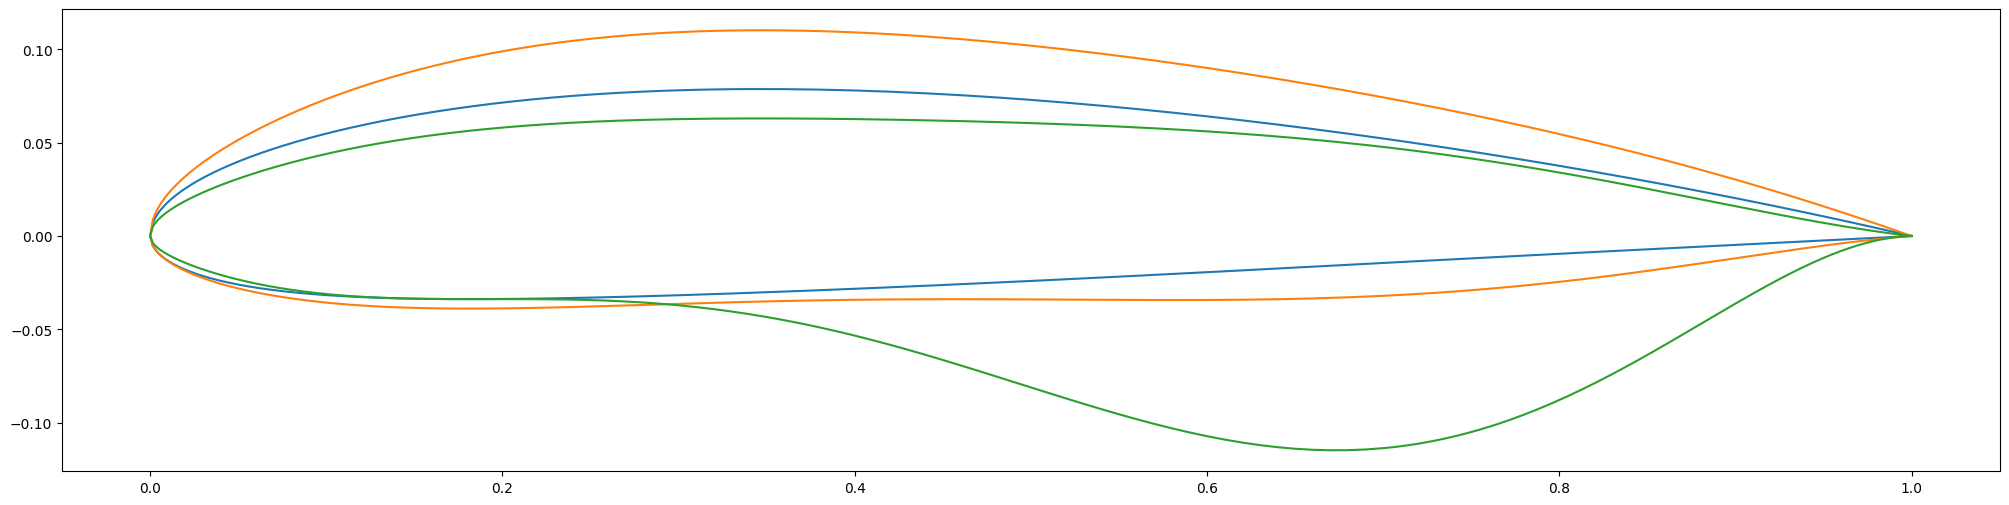

In [23]:
plt.figure(figsize=(25,6))
j=50
t=150
plot_combi(100,100,100,100,100,100,100,100)
plot_combi(t,t,t,t,100,t,140,115)
plot_combi(j,j,j,j,50,j,80,100)


<h3>->Impresión de varios perfiles

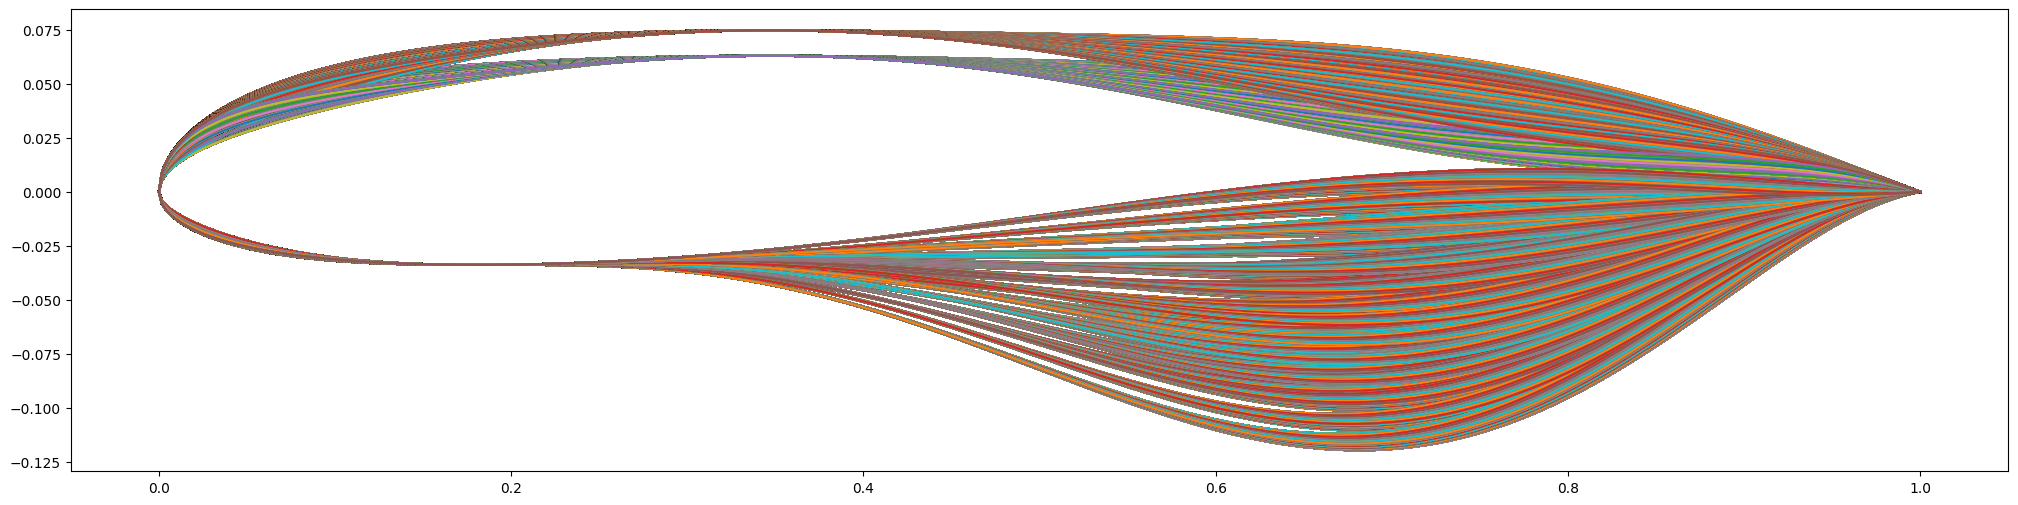

In [24]:
plt.figure(figsize=(25,6))
t=15
m=50
ma=150
for i in range(m,ma,t):
    for j in range(m,ma,t):
        for k in range(m,ma,t):
            for re in range(m,ma,t):
                for ra in range(50,100,t):
                    for b in range(m,ma,t):
                        for ye in range(80,100,t):
                            for yi in range(100,101,t):
                                plot_combi(i,j,k,re,ra,b,ye,yi)

<h2>5. Creación de documentos para la simulación en Xfoil

Geometría del perfil

In [25]:
def create_coord_file(xx,yy,fname):
    test_result=""
    for i in range(len(xx)):
        x=xx[i]
        y=yy[i]
        test_result += f"{x:.6f}" + (" "*(4 if y >= 0 else 3)) + f"{y:.6f}\n"
    test_result
    file=open(fname + ".dat","w")
    file.write(test_result)
    file.close()

Datos de simulación que ingresan a Xfoil y creación de archivo "resultados"

In [80]:
def run_simulation(i,j,k,re,ra,b,ye,yi,fname=None):
    xx,yy=get_coord_combi(i,j,k,re,ra,b,ye,yi)
    if fname is None:
        fname=f"Naca2411/barrido/sim_{i}_{j}_{k}_{re}_{ra}_{b}_{ye}_{yi}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = -20
    alpha_f = 180
    alpha_step = 1
    Re = 25000
    n_iter = 100

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')
    input_file.write("MDES\n")
    input_file.write("FILT\n") 
    input_file.write("EXEC\n")
    input_file.write("\n")
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f, alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    process = subprocess.Popen("xfoil.exe < " + fname + ".in", shell=True)

    try:
        process.wait(timeout=50)
    except subprocess.TimeoutExpired:
        for child in psutil.Process(process.pid).children(recursive=True):
            child.kill()
        process.kill()

        print("killed " + fname + " after timeout")

In [81]:
run_simulation(100,100,100,100,100,100,100,100)

Se indica a Xfoil que corra los datos anteriores

In [ ]:
if x

In [28]:
#t=15
#m=50
#ma=150
#for i in range(m,ma,t):
#    for j in range(m,ma,t):
#        for k in range(m,ma,t):
#            for re in range(m,ma,t):
#                for ra in range(50,100,t):
#                    for b in range(m,ma,t):
#                        for ye in range(80,100,t):
#                           for yi in range(100,101,t):
#                                run_simulation(i,j,k,re,ra,b,ye,yi)

<h2>6. Lectura de archivos para comparar el mejor


Lectura de archivo

In [29]:
def get_params_from_fname(fname):
    params = regex.search(r'sim_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.txt', fname)
    return [params.group(i) for i in range(1, 9)]

Ingreso al documento para separar las columnas de los archivos 

In [30]:
def filter_empty(values):
  return list(filter(lambda line: False if line == "" else True, values))

def get_values(line):
  values = regex.split(r'\s+', line)
  values = filter_empty(values)
  return list(map(float, values))

def get_table(file):
  match_ = regex.search(r'((?:-{2,} *)+)', file)
  match_.groups(1)
  
  table = file[match_.end(1): len(file)]
  lines = table.split("\n")
  lines = filter_empty(lines)

  values = list(map(get_values, lines))
  return values

Calculo de la eficiencia dentro de los archivos 

In [88]:
def get_value(table):
    cl_values=list(map(lambda line: line[1]/line[2], table))
    prom=np.max(cl_values) if len(cl_values) > 0  else -math.inf
    return prom
    #return cl_values[6]

Por medio de "Queue" biblioteca de python se crea una lista de prioridad que permite ver el rango entre los parametros 

In [89]:
X=PriorityQueue()
queue_index=PriorityQueue()


In [90]:
def key_from_params(params):
  n = len(params)

  t = 0

  for i in range(n):
    v = int(params[n - i - 1])
    m = 10**(i*3)
    t += m*v

  return t

In [91]:
for name in glob.glob('./naca2411/barrido/sim*.txt'):
    f = open(name, "r")
    content=f.read()
    params=get_params_from_fname(name)
    values = get_table(content)
    result=get_value(values) 
    if not math.isfinite(result):
        continue
    X.put((-result,params))#El orden da negativo pero no es el valor real, son positivos 

    order=key_from_params(params)
    queue_index.put((order,result))#ordenar de acuerdo a la combinacion

    f.close()    

<h1> 7. Lista ordenada de mejores eficiencias a peores

In [92]:
n = 0
top=[]
while not X.empty():
    priority,params = X.get()
    priority*=-1
    top.append((priority,params))
    n += 1
display(top)

[(433.14410480349346, ['140', '110', '140', '140', '20', '50', '160', '100']),
 (345.7307692307693, ['110', '110', '140', '110', '20', '50', '160', '100']),
 (338.6080586080586, ['140', '110', '140', '80', '20', '110', '160', '100']),
 (327.69531249999994, ['140', '80', '140', '140', '20', '50', '130', '100']),
 (311.9642857142857, ['50', '80', '140', '140', '20', '80', '130', '100']),
 (288.5668789808917, ['110', '80', '140', '140', '20', '140', '130', '100']),
 (250.64417177914112, ['110', '80', '140', '80', '20', '110', '160', '100']),
 (238.91891891891893, ['50', '80', '110', '80', '20', '50', '100', '100']),
 (236.0850111856823, ['140', '140', '110', '140', '20', '50', '160', '100']),
 (213.89655172413794, ['140', '110', '140', '110', '20', '50', '190', '100']),
 (208.03719008264463, ['110', '140', '110', '140', '20', '80', '160', '100']),
 (201.08317214700193, ['80', '140', '110', '80', '20', '140', '100', '100']),
 (200.3113553113553, ['140', '80', '110', '140', '20', '140', '16

->Orden de archivos 


In [93]:
n2=0
top_order=[]
while not queue_index.empty():
    _,params = queue_index.get()
    top_order.append((n2,params))
    n2 += 1
display(top_order)

[(0, 39.748036649214654),
 (1, 20.381597717546363),
 (2, 23.31333904598686),
 (3, 20.76561976081368),
 (4, 18.00748836267962),
 (5, 16.688294607628233),
 (6, 40.74026802807913),
 (7, 32.10971334295731),
 (8, 23.010176017601758),
 (9, 16.304923239809423),
 (10, 15.193932080675745),
 (11, 31.748313288354357),
 (12, 22.944235770008667),
 (13, 16.9326125454376),
 (14, 33.910630841121495),
 (15, 21.726372637263726),
 (16, 20.353872803761444),
 (17, 17.278071722516167),
 (18, 14.234284351903362),
 (19, 29.86466607825831),
 (20, 22.847462968799242),
 (21, 12.581531832701879),
 (22, 11.928406466512703),
 (23, 29.985465116279073),
 (24, 21.546367671104882),
 (25, 15.76785714285714),
 (26, 14.18260435722601),
 (27, 20.38407960199005),
 (28, 16.10530391018196),
 (29, 11.851401963761514),
 (30, 12.674062180703546),
 (31, 35.185304543989695),
 (32, 27.63718023823472),
 (33, 23.958965467418004),
 (34, 22.337646180641954),
 (35, 17.829977628635348),
 (36, 40.747782002534855),
 (37, 30.49302691023375)

<h2> Graficas que muestran el comportamiento de las diferentes combinaciones

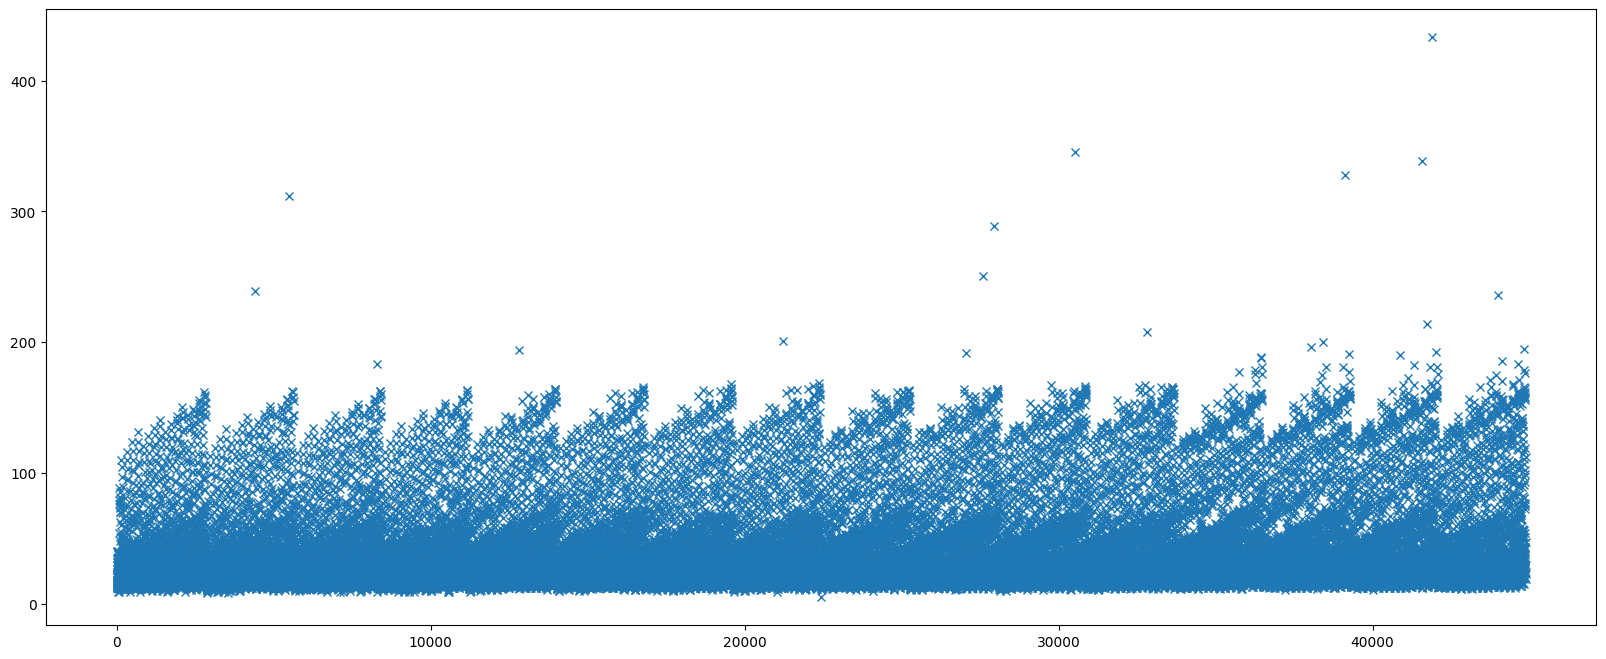

In [94]:
x = list(map(lambda x: x[0], top_order))
y = list(map(lambda x: x[1], top_order))
plt.figure(figsize=(20,8))
plt.plot(x,y,"x")

In [ ]:
uid=int(0)
def evalue_sim(x):
    global uid
    i,j,k,re,ra,yi,ye,b=x
    name=f"results_opt/_sim_{uid}"
    name2=name
    run_simulation(i,j,k,re,ra,yi,ye,b,fname=name) #asignar a la fuerza un nombre 
    name+=".txt"
    f = open(name, "r")
    content=f.read()
    values = get_table(content)
    result=get_value(values)
    f.close()
    os.remove(name2+".dat")
    try:
        os.remove(name2+".in")
    except PermissionError:
        print("PermissionError")
    uid+=1
    return result

In [ ]:
history=[]
def evalue_sim_save(v_var):
    results_opt=-evalue_sim(v_var)
    history.append(results_opt)
    return results_opt

In [ ]:
m=50
ma=150
rangei=(m,ma)
rangej=(m,ma)
rangek=(m,ma)
rangere=(m,ma)
rangera=(50,100)
rangeb=(m,ma)
rangeye=(80,100)
rangeyi=(100,101)
maxim = dual_annealing(evalue_sim_save, bounds=(rangei, rangej, rangek,rangere,rangera,rangeb,rangeye,rangeyi),maxiter=2500)
maxim

killed results_opt/_sim_5560 after timeout
PermissionError
killed results_opt/_sim_9143 after timeout
PermissionError
killed results_opt/_sim_11603 after timeout
PermissionError
killed results_opt/_sim_12049 after timeout
PermissionError
killed results_opt/_sim_17080 after timeout
PermissionError
killed results_opt/_sim_17803 after timeout
PermissionError
killed results_opt/_sim_18635 after timeout
PermissionError
killed results_opt/_sim_25420 after timeout
PermissionError
killed results_opt/_sim_27298 after timeout
PermissionError
killed results_opt/_sim_28398 after timeout
PermissionError
killed results_opt/_sim_31858 after timeout
PermissionError
killed results_opt/_sim_32171 after timeout
PermissionError
killed results_opt/_sim_35006 after timeout
PermissionError
killed results_opt/_sim_35647 after timeout
PermissionError
killed results_opt/_sim_46093 after timeout
PermissionError
killed results_opt/_sim_48224 after timeout
PermissionError
killed results_opt/_sim_52963 after timeou

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -1.5936
       x: [ 5.002e+01  1.500e+02  1.500e+02  1.498e+02  1.000e+02
            5.001e+01  9.999e+01  1.000e+02]
     nit: 10000
    nfev: 169747
    njev: 1082
    nhev: 0

In [ ]:
history2=list(map(lambda x:-x,filter(lambda x:math.isfinite(x),history)))
print(history2)

[0.8799, 1.2361, 1.1792, 1.0952, 1.1198, 1.0017, 1.1485, 1.1329, 1.2536, 1.2417, 1.2835, 1.3992, 1.2969, 1.3601, 1.3646, 1.3408, 1.3497, 1.3992, 1.3992, 1.3992, 1.3992, 1.3992, 1.3992, 1.3992, 1.3992, 1.3992, 1.0788, 0.8727, 0.9895, 1.0895, 1.2214, 1.3435, 1.1324, 1.192, 1.1918, 1.2065, 1.1216, 1.0889, 1.2317, 1.3198, 1.3267, 1.3195, 1.3027, 1.1859, 1.221, 1.314, 1.2757, 0.9961, 0.8994, 1.2245, 1.2462, 1.3018, 1.1174, 1.1262, 1.416, 1.2912, 1.2886, 1.1843, 1.416, 1.416, 1.416, 1.416, 1.416, 1.416, 1.416, 1.416, 1.416, 1.0407, 1.0631, 1.2324, 0.831, 1.1083, 1.1027, 1.1672, 1.0135, 1.0531, 0.9778, 1.3148, 1.3139, 1.2228, 1.2376, 1.2259, 1.226, 0.8338, 1.0971, 1.2737, 1.1527, 1.0146, 1.2125, 0.8535, 0.9477, 0.9496, 0.9358, 0.8812, 0.8839, 0.8731, 1.0197, 0.9921, 0.997, 1.1026, 0.9662, 1.2416, 0.8405, 1.1502, 1.1435, 0.7359, 1.1914, 1.1978, 1.2024, 1.1985, 1.2009, 1.1034, 1.0555, 1.0104, 1.0135, 1.3623, 1.0539, 1.0562, 1.1585, 0.9077, 1.0713, 1.0594, 1.1048, 1.1073, 1.0611, 1.1069, 1.106, 

In [95]:
plt.figure(figsize=(25,6))
plt.plot(history2)


NameError: name 'history2' is not defined

<Figure size 2500x600 with 0 Axes>

In [ ]:
maxim.x

array([ 50.01723758, 149.95296856, 149.99366429, 149.80945647,
        99.99981861,  50.00833412,  99.98961196, 100.0002991 ])

In [ ]:
run_simulation(95.40293966,  69.33806829,  62.23350334, 108.329548  ,        26.49750037, 143.21811965, 102.41183815, 196.09084003)

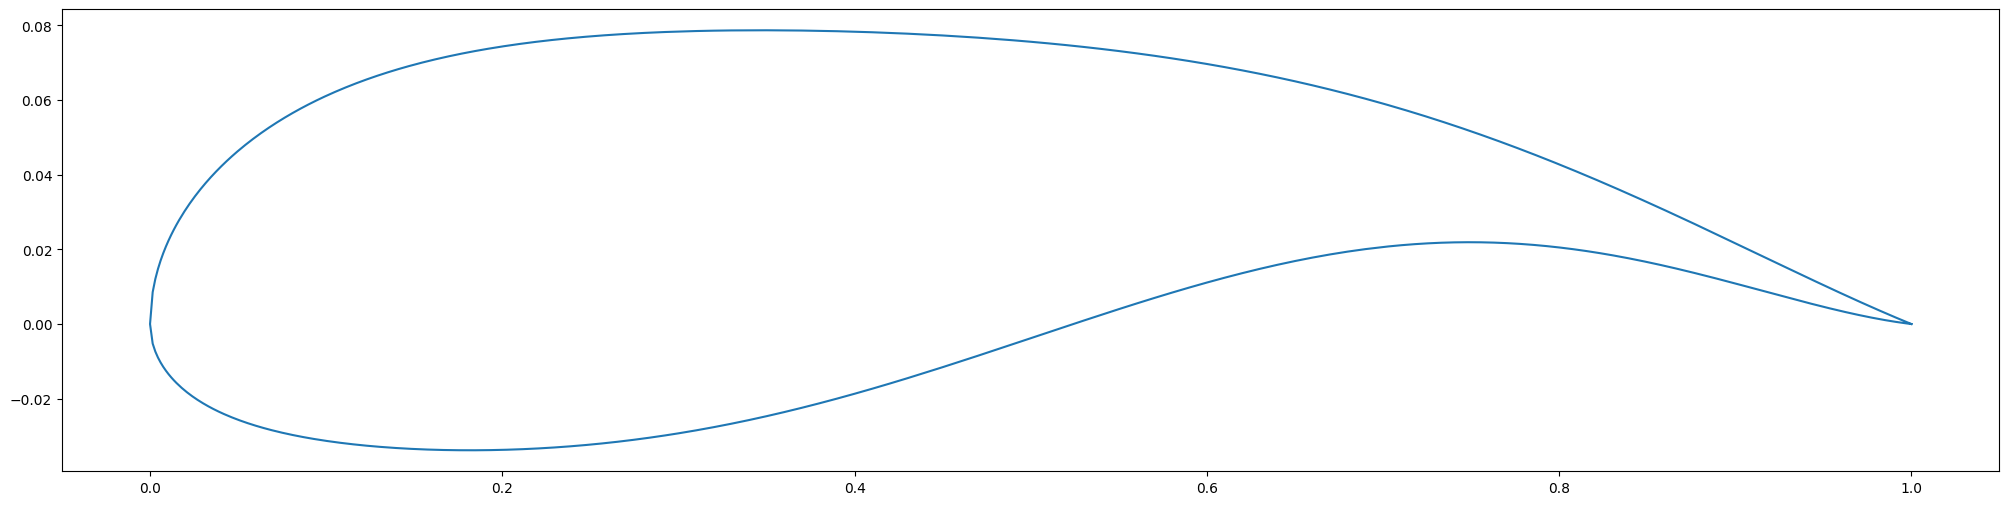

In [ ]:
plt.figure(figsize=(25,6))
plot_combi(50.01453633, 149.98722677, 149.98587464, 148.99955308,        99.99078072,  50.01799074,  99.99763749, 100.00440575)

<h1> Evaluación de iteraciones Xfoil

In [ ]:
def run2_simulation(i,j,k,fname=None):
    xx,yy=get_coord_combi(i,j,k)
    if fname is None:
        fname=f"Evalue_it/sim_{w}_{i}_{j}_{k}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = 1
    alpha_f = 10
    alpha_step = 1
    Re = 10000
    n_iter = w

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')  
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f, alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    process = subprocess.Popen("xfoil.exe < " + fname + ".in", shell=True)

    try:
        process.wait(timeout=60)
    except subprocess.TimeoutExpired:
        for child in psutil.Process(process.pid).children(recursive=True):
            child.kill()
        process.kill()

        print("killed " + fname + " after timeout")
    

In [ ]:
#for w in range(1,100,10):
#    run2_simulation(100,100,100)

#for w in range(100,1000,100):
#    run2_simulation(100,100,10)

In [ ]:
def get_params_from_fname2(fname):
    params = regex.search(r'sim_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.txt', fname)
    return [params.group(i) for i in range(1, 4)]

In [ ]:
def filter_empty2(values):
  return list(filter(lambda line: False if line == "" else True, values))

def get_values2(line):
  values = regex.split(r'\s+', line)
  values = filter_empty2(values)
  return list(map(float, values))

def get_table2(file):
  match_ = regex.search(r'((?:-{2,} *)+)', file)
  match_.groups(1)
  
  table = file[match_.end(1): len(file)]
  lines = table.split("\n")
  lines = filter_empty2(lines)

  values = list(map(get_values2, lines))
  return values

In [ ]:
def get_value2(table):
    cl_values=list(map(lambda line: line[1], table))
    prom=np.mean(cl_values)  
    return prom
    #return cl_values[6]

In [ ]:
X=PriorityQueue()

In [ ]:
for name in glob.glob('./Evalue_it/sim_*.txt'):
    f = open(name, "r")
    content=f.read()
    params=get_params_from_fname2(name)
    values = get_table2(content)
    result=get_value2(values)
    X.put((-result,params))#El orden da negativo pero no es el valor real, son positivos 
    f.close()

In [ ]:
n = 0
top=[]
while not X.empty():
    priority,params = X.get()
    priority*=-1
    top.append((priority,params))
    n += 1
display(top)

[]

In [ ]:
w = [None] * 19  # Assuming you want a list of size 20 for this example
i = 0  # Initialize the index variable
for e in range(1, 100, 10):
    w[i] = e
    i += 1  # Increment the index variable

# Ensure that the index doesn't go out of bounds
for e in range(100, 1000, 100):
    if i < len(w):  # Check if the index is within the bounds of the list
        w[i] = e
        i += 1


In [ ]:
CL=[]
I=[]
J=[]
K=[]
for cl, (i, j, k) in top:
    CL.append(cl)
    I.append(float(i))
    J.append(float(j))
    K.append(float(k))

In [ ]:
CL=np.array(CL)
Cl_n=((abs(CL-0.3938))/0.3938)*100

In [ ]:
len(Cl_n)

0

ValueError: x and y must have same first dimension, but have shapes (19,) and (0,)

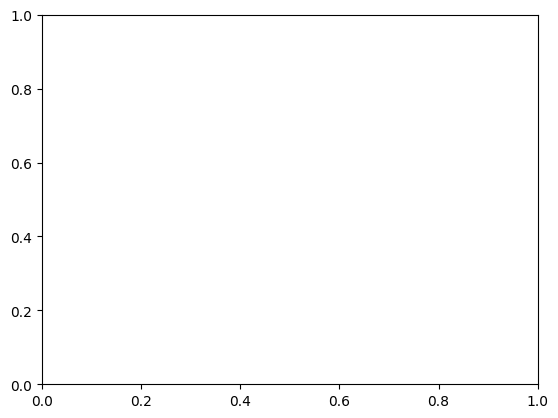

In [ ]:
# Simulate data similar to the uploaded image
iterations = w
objective_values = CL

# Create a line plot
plt.plot(iterations, objective_values, color='black', linewidth=1)
plt.title("Iteraciones de Xfoil")
plt.xlabel("Número de iterationes")
plt.ylabel("CL")
plt.grid(True)
plt.xticks(range(0, max(iterations)+2, 100))  # Cambia el último valor (100) según tus necesidades
# Configura las etiquetas en el eje Y manualmente
yticks = np.linspace(0.6, 1, 21)  # Crea 20 etiquetas entre 0.6 y 1
plt.yticks(yticks)
plt.show()